In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from scipy.optimize import curve_fit

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
try:
    import ROOT
except ImportError as e:
    env_lib = Path(os.environ['CONDA_PREFIX']) / 'lib'
    sys.path.append(list(env_lib.glob('python*/site-packages'))[-1])
    import ROOT


/opt/root/root-6.30.06-install/lib/cppyy/__init__.py:72: SyntaxWarning: invalid escape sequence '\d'
  if re.match('^libcppyy_backend\d+_\d+$', lib_name):
/opt/root/root-6.30.06-install/lib/cppyy/__init__.py:72: SyntaxWarning: invalid escape sequence '\d'
  if re.match('^libcppyy_backend\d+_\d+$', lib_name):
/opt/root/root-6.30.06-install/lib/cppyy/__init__.py:72: SyntaxWarning: invalid escape sequence '\d'
  if re.match('^libcppyy_backend\d+_\d+$', lib_name):


ImportError: Failed to import libcppyy3_12. Please check that ROOT has been built for Python 3.12

: 

In [36]:
def TH1D_to_df(hist,  xname='x', yname='y', keep_zeros=True):
    df = dict()
    columns = [xname, yname, f'{yname}_err']
    getters = [hist.GetXaxis().GetBinCenter, hist.GetBinContent,
                hist.GetBinError]
    for col, get in zip(columns, getters):
        df[col] = [get(b) for b in range(1, hist.GetNbinsX() + 1)]

    df = pd.DataFrame(df)
    condition = (df[yname] != 0.0)
    df[f'{yname}_ferr'] = np.where(
        condition, np.abs(df[f'{yname}_err']/df[yname]), 0.0)

    return df if keep_zeros else df.query(f'{yname} != 0.0').reset_index(drop=True)


def TH2D_to_df(histo, xname='x', yname='y', zname='z', keep_zeros=True):
    x = np.array([histo.GetXaxis().GetBinCenter(b)
                    for b in range(1, histo.GetNbinsX() + 1)])
    y = np.array([histo.GetYaxis().GetBinCenter(b)
                    for b in range(1, histo.GetNbinsY() + 1)])

    content = np.array(histo)
    content = content.reshape(len(x) + 2, len(y) + 2, order='F')
    content = content[1:-1, 1:-1]

    error = np.array([histo.GetBinError(b)
                        for b in range((len(x) + 2) * (len(y) + 2))])
    error = error.reshape(len(x) + 2, len(y) + 2, order='F')
    error = error[1:-1, 1:-1]

    xx, yy = np.meshgrid(x, y, indexing='ij')
    df = pd.DataFrame({
        xname: xx.flatten(),
        yname: yy.flatten(),
        zname: content.flatten(),
        f'{zname}_err': error.flatten(),
    })
    mask = (df[zname] != 0.0)
    df[f'{zname}_ferr'] = np.where(
        mask,
        np.abs(df[f'{zname}_err'] / df[zname]),
        0.0
    )
    return df if keep_zeros else df.query(f'{zname} != 0.0').reset_index(drop=True)


: 

In [37]:
n_layers = 3
n_modules_per_layer = 24

def get_module_id(layer, i_module):
    return layer * n_modules_per_layer + i_module

def get_layer(module_id):
    return module_id // n_modules_per_layer

def get_layer_module(module_id):
    return module_id // n_modules_per_layer, module_id % n_modules_per_layer


: 

In [38]:
calib_file = ROOT.TFile('tdiff.root', 'read')
input_histograms = {}
for key in calib_file.GetListOfKeys():
    input_histograms[key.GetName()] = key.ReadObj()

: 

In [39]:
input_histograms

{'hModuleIDVsTDiff': <cppyy.gbl.TH2D object at 0x560c4c2acaf0>,
 'hModuleIDVsTDiffLayer0': <cppyy.gbl.TH2D object at 0x560c4bd21730>,
 'hModuleIDVsTDiffLayer0Gated': <cppyy.gbl.TH2D object at 0x560c4bd2fac0>,
 'hModuleIDVsTDiffLayer1': <cppyy.gbl.TH2D object at 0x560c4bacf680>,
 'hModuleIDVsTDiffLayer1Gated': <cppyy.gbl.TH2D object at 0x560c4ba368a0>,
 'hModuleIDVsTDiffLayer2': <cppyy.gbl.TH2D object at 0x560c4bacd9f0>,
 'hModuleIDVsTDiffLayer2Gated': <cppyy.gbl.TH2D object at 0x560c4baedd90>}

: 

In [40]:
projected_tdiff = OrderedDict()
for layer, module in itertools.product(range(n_layers), range(n_modules_per_layer)):
    module_id = get_module_id(layer, module)
    hist = input_histograms[f'hModuleIDVsTDiffLayer{layer}Gated'].ProjectionX(
        f'mod_{module_id}', module_id + 1, module_id + 1
    )
    projected_tdiff[module_id] = TH1D_to_df(hist)

: 

In [41]:
offset_file = 'tdiff_offset.json'
tdiff_offset = None

if os.path.exists(offset_file):
    print(f'found {offset_file}, loading to dictionary.')
    with open(offset_file, 'r') as f:
        tdiff_offset = json.load(f)

else:
    print(f'unable to find {offset_file}, creating new one.')
    tdiff_offset = {
        int(mod + layer * n_modules_per_layer) : 0 for layer, mod in itertools.product(range(n_layers), range(n_modules_per_layer))
    }
    with open('tdiff_offset.json', 'w') as f:
        json.dump(tdiff_offset, f)

found tdiff_offset.json, loading to dictionary.


: 

In [42]:
# module IDs used to gate the tdiff histograms
tdiff_offset['layer1_gate'] = [28, 35, 42]
tdiff_offset['layer2_gate'] = [4, 11, 18]
tdiff_offset['layer3_gate'] = [28, 35, 42]

tdiff_offset['runIds'] = [
    1148, 1150, 1151, 1152, 1153, 1154, 1155, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1221, 1222, 1223, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1234, 1235, 1236, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1268, 1269, 1273, 1274, 1275, 1276, 1277, 1279, 1280, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299,
]

: 

In [43]:
def gaussian(x, amp, mean, sigma, bg):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2) + bg

def fit_gaussian(df, p0=None, range=None):
    if range is not None:
        df = df.query(f'{range[0]} <= x <= {range[1]}')

    popt, _ = curve_fit(
        gaussian, 
        df['x'], 
        df['y'], 
        p0=p0
    )
    return popt

: 

### run multiple times to get the right fit

In [44]:
module_id = 71
df = projected_tdiff[module_id]

: 

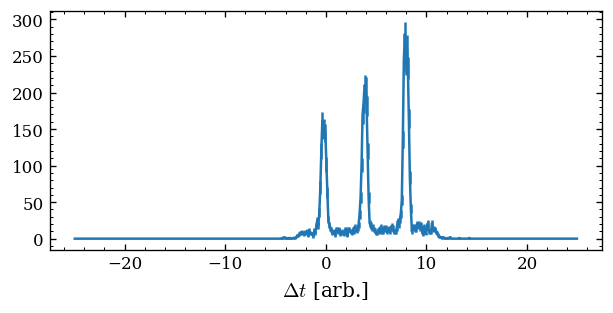

: 

In [45]:
fig, ax = plt.subplots(1,1,figsize=(5,2.5),constrained_layout=True,dpi=120)
ax.errorbar(df['x'], df['y'], yerr=df['y_err'])
ax.set_xlabel(r'$\Delta t$ [arb.]', fontsize=12)
plt.show()

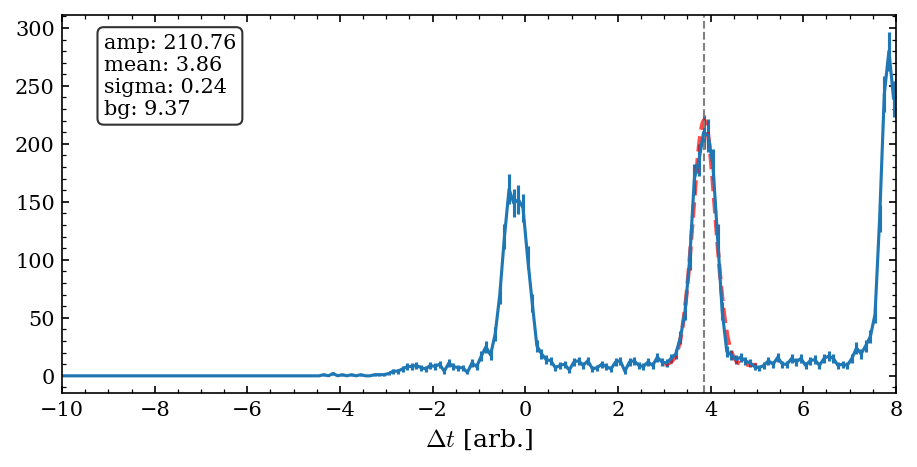

: 

In [46]:
xlim = [-10, 8]
xrange = [3, 5]
amp = 250
mean = 4.05
sigma = 0.8
bg = 5

x = np.linspace(*xrange, 1000)
popt = fit_gaussian(df, p0=[amp, mean, sigma, bg], range=xrange)

fig, ax = plt.subplots(1,1,figsize=(6,3),constrained_layout=True,dpi=150)
ax.errorbar(df['x'], df['y'], yerr=df['y_err'])
ax.plot(x, gaussian(x, *popt), label='fit', color='red', alpha=0.7, lw=2, ls='--')

ax.axvline(popt[1], color='gray', ls='--', lw=1)
ax.set_xlim(*xlim)

ax.set_xlabel(r'$\Delta t$ [arb.]', fontsize=12)

ax.annotate(
    f'amp: {popt[0]:.2f}\nmean: {popt[1]:.2f}\nsigma: {popt[2]:.2f}\nbg: {popt[3]:.2f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    ha='left',
    va='top',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.show()


In [47]:
# update offset and overwrite the json file
tdiff_offset.pop(module_id, None)
tdiff_offset[module_id] = popt[1]
with open('tdiff_offset.json', 'w') as f:
    json.dump(tdiff_offset, f)

# reload 
# with open('tdiff_offset.json', 'r') as f:
#     tdiff_offset = json.load(f)

: 

: 